In [1]:
import csv
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import numpy as np
import math
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score

In [2]:
clean_labels_path = '/dhc/groups/ocdetect/thesis/cleaned_labels'
labels_windows_clean = '/dhc/groups/ocdetect/thesis/cleaned_windows'
label_windows = '/dhc/groups/ocdetect/thesis/label_windows'
extracted_labels = '/dhc/groups/ocdetect/thesis/extracted_labels'
subjects = ["01", "03", "04", "18", "20", "30"]
annotators = ["a1", "a2", "a3", "a4"]
colors = ['#F6A800', '#8B9094', '#B1063A', '#5A6065', '#DD6108', "#ABAFB2", ]

   Subject Annotator  Number of Set Labels  After Clean
0       01        a1                   235          211
1       01        a4                   195          190
2       03        a1                   208          205
3       03        a2                   212          209
4       04        a2                   115          115
5       04        a3                   127          123
6       18        a1                   308          288
7       18        a3                   347          312
8       20        a3                   343          340
9       20        a4                   323          323
10      30        a2                   169          162
11      30        a4                   124          121


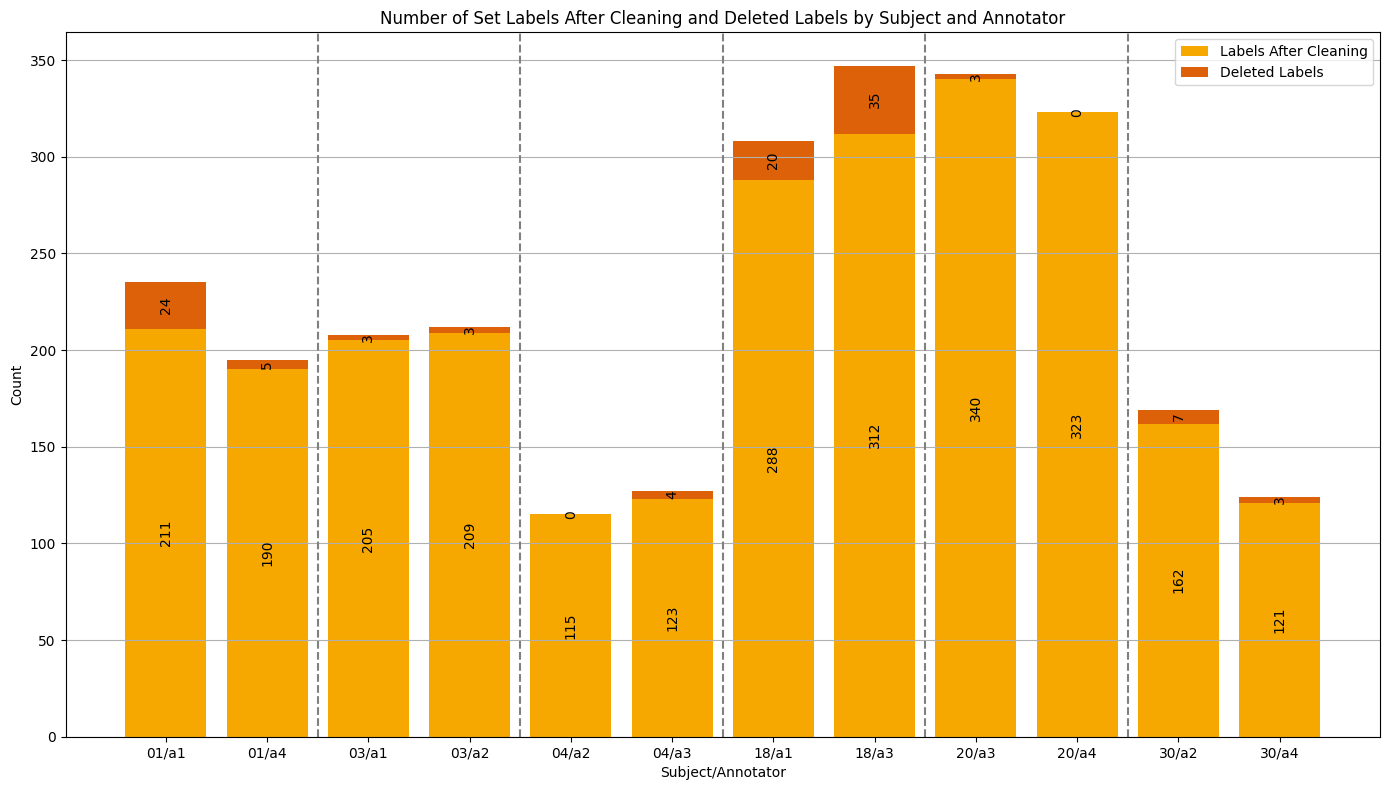

In [6]:
# Number of set labels by annotator per subject 
def calculate_number_of_set_labels_by_subject_and_annotator():
    data = []      
    for subject in subjects:
        for annotator in annotators:
            path = os.path.join(extracted_labels, f"{annotator}_subject_{subject}.csv")
            if os.path.exists(path):
                num_labels = len(pd.read_csv(path))
                clean_path = os.path.join(clean_labels_path,  f"{annotator}_subject_{subject}.csv")
                after_clean = len(pd.read_csv(clean_path))
                data.append([subject, annotator, num_labels, after_clean])

    columns = ["Subject", "Annotator", "Number of Set Labels", "After Clean"]
    set_labels_count_df = pd.DataFrame(data, columns=columns)
    set_labels_count_df['Subject'] = set_labels_count_df['Subject'].astype(str)
    return set_labels_count_df
set_labels_count_df = calculate_number_of_set_labels_by_subject_and_annotator()
print(set_labels_count_df)
df = set_labels_count_df.sort_values(by='Subject')


df['Deleted Labels'] = df['Number of Set Labels'] - df['After Clean']
df['Subject/Annotator'] = df['Subject'] + '/' + df['Annotator']
positions = []


current_pos = 0
positions.append(current_pos)


for i in range(1, len(df)):
    if i % 2 == 0: 
        current_pos += 2  
    else:
        current_pos += 1 
    positions.append(current_pos)

plt.figure(figsize=(14, 8))
x = np.arange(len(df))
width = 0.8


plt.bar(x, df['After Clean'], width=width, color=colors[0], label='Labels After Cleaning')
plt.bar(x, df['Deleted Labels'], bottom=df['After Clean'], width=width, color=colors[4], label='Deleted Labels')

plt.xlabel('Subject/Annotator')
plt.ylabel('Count')
plt.title('Number of Set Labels After Cleaning and Deleted Labels by Subject and Annotator')
plt.xticks(x, df['Subject/Annotator'], rotation=0, ha='center')
plt.legend()
plt.grid(axis='y')


for i, (after_clean, deleted_labels) in enumerate(zip(df['After Clean'], df['Deleted Labels'])):
    plt.text(i, after_clean / 2, f'{int(after_clean)}', ha='center', va='center', color='black', rotation=90)
    plt.text(i, after_clean + deleted_labels / 2, f'{int(deleted_labels)}', ha='center', va='center', color='black', rotation=90)
for i in range(1, len(df)//2):
    plt.axvline(x=2*i - 0.5, color='grey', linestyle='--')
 
plt.tight_layout()
plt.savefig('number_of_labels.png')
plt.show()

  Subject  Number of Windows  After Clean
0      01                362          348
1      03                225          221
2      04                130          130
3      18                398          355
4      20                366          366
5      30                195          184


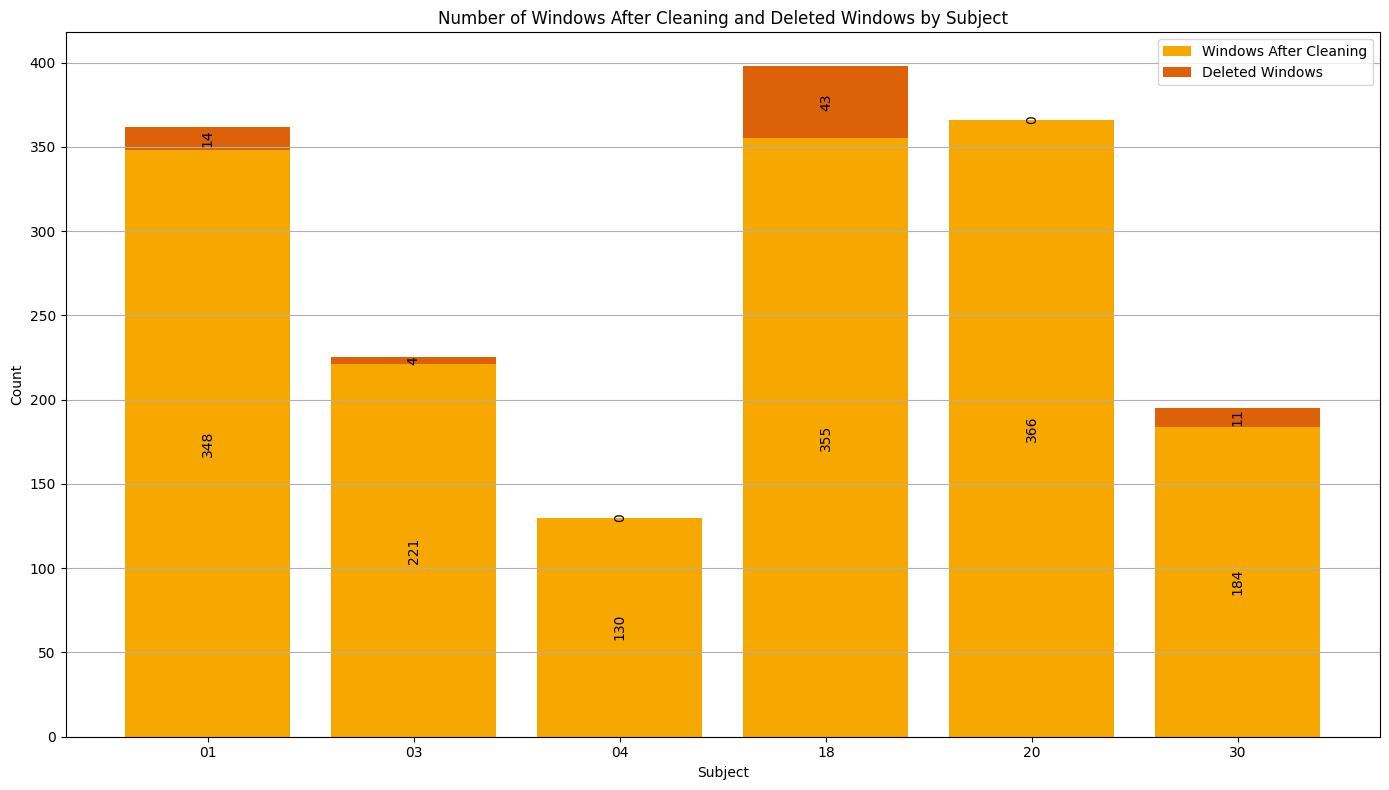

In [7]:
def calculate_number_of_windows_labels_by_subject_and_annotator():
    data = []      
    for subject in subjects:
        path = os.path.join(label_windows, f'subject_{subject}.csv')
        if os.path.exists(path):
            num_wwindows = len(pd.read_csv(path))
            clean_path = os.path.join(labels_windows_clean,  f"subject_{subject}.csv")
            after_clean = len(pd.read_csv(clean_path))
            data.append([subject, num_wwindows, after_clean])

    columns = ["Subject", "Number of Windows", "After Clean"]
    set_labels_count_df = pd.DataFrame(data, columns=columns)
    set_labels_count_df['Subject'] = set_labels_count_df['Subject'].astype(str)
    return set_labels_count_df
set_labels_count_df = calculate_number_of_windows_labels_by_subject_and_annotator()
print(set_labels_count_df)
df = set_labels_count_df.sort_values(by='Subject')


df['Deleted Windows'] = df['Number of Windows'] - df['After Clean']
df['Subject/Annotator'] = df['Subject']


plt.figure(figsize=(14, 8))
x = np.arange(len(df))
width = 0.8


plt.bar(x, df['After Clean'], width=width, color=colors[0], label='Windows After Cleaning')
plt.bar(x, df['Deleted Windows'], bottom=df['After Clean'], width=width, color=colors[4], label='Deleted Windows')

plt.xlabel('Subject')
plt.ylabel('Count')
plt.title('Number of Windows After Cleaning and Deleted Windows by Subject')
plt.xticks(x, df['Subject'], rotation=0, ha='center')
plt.legend()
plt.grid(axis='y')

# Add text labels for each part of the bar
for i, (after_clean, deleted_labels) in enumerate(zip(df['After Clean'], df['Deleted Windows'])):
    plt.text(i, after_clean / 2, f'{int(after_clean)}', ha='center', va='center', color='black', rotation=90)
    plt.text(i, after_clean + deleted_labels / 2, f'{int(deleted_labels)}', ha='center', va='center', color='black', rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

In [8]:
#calculate cohen's kappa, precision, recall, jaccard index, variance for number of labels


def get_confusion_matrix(windows, file1, file2):
    contigency_matrix = {
    'pp': 0,
    'pn': 0,
    'np': 0,
    'nn': 0
    }
    for index, row in windows_df.iterrows():
        start_w = row['start']
        end_w = row['end']
        presence1 = file1[(file1['start'] >= start_w) & (file1['start'] <= end_w)].shape[0] > 0
        presence2 = file2[(file2['start'] >= start_w) & (file2['start'] <= end_w)].shape[0] > 0
    
        if presence1 and presence2:
            contigency_matrix['pp'] += 1
        elif not presence2 and presence1:
            contigency_matrix['pn'] += 1
        elif not presence1 and presence2:
            contigency_matrix['np'] += 1
        else:
            contigency_matrix['nn'] += 1
    print('matrix')
    print(contigency_matrix)
    return contigency_matrix

def calculate_jaccard_index(df, file_1, file_2):
    table = get_confusion_matrix(df, file_1, file_2)
    return (table['pp'] + table['nn'])/(table['pp'] + table['pn'] + table['np'] + table['nn'])

def get_labels_binary(windows_df, file1, file2):
    classification1 = []
    classification2 = []

    for index, row in windows_df.iterrows():
        start_w = row['start']
        end_w = row['end']
        
        presence1 = file1[(file1['start'] >= start_w) & (file1['start'] <= end_w)].shape[0] > 0
        classification1.append(1 if presence1 else 0)

        presence2 = file2[(file2['start'] >= start_w) & (file2['start'] <= end_w)].shape[0] > 0
        classification2.append(1 if presence2 else 0)
        
    
    return classification1, classification2


    
    
scores = []
for subject in subjects:
    kappa = 0
    windows_path = os.path.join(labels_windows_clean, f'subject_{subject}.csv')
    windows_df = pd.read_csv(windows_path)
    windows_df['start'] = pd.to_datetime(windows_df['start']) # change later
    windows_df['end'] = pd.to_datetime(windows_df['end'])
    annotator_dfs = []
    annotator_pair = []
    for annotator in annotators:
        index = 0
        path = os.path.join(clean_labels_path, f'{annotator}_subject_{subject}.csv')

        if os.path.exists(path):
            file1 = pd.read_csv(path)
            file1['start'] = pd.to_datetime(file1['start'])
            file1['end'] = pd.to_datetime(file1['end'])
            annotator_pair.append(annotator)
            annotator_dfs.append(file1)

            
    annotator1, annotator2 = get_labels_binary(windows_df, annotator_dfs[0], annotator_dfs[1])
    with np.errstate(divide='ignore', invalid='ignore'):
        kappa = cohen_kappa_score(np.array(annotator1), np.array(annotator2))
    # Treat annotator1 as the ground truth and annotator2 as predictions
    precision = precision_score(annotator1, annotator2)
    recall = recall_score(annotator1, annotator2)
    f1 = f1_score(annotator1, annotator2)
    jaccard_similarity = calculate_jaccard_index(windows_df, annotator_dfs[0], annotator_dfs[1])
  

    scores.append({'Subject': subject, 
                   'Annotator pair': f'{annotator_pair[0]}/{annotator_pair[1]}', 
                   'Cohens Kappa': kappa, 
                   'Precision': precision, 
                  'Recall': recall, 
                   'F1 Score': f1,
                  'Jaccard Index': jaccard_similarity})
scores_df = pd.DataFrame(scores)
print(scores_df)    

matrix
{'pp': 168, 'pn': 43, 'np': 22, 'nn': 115}
matrix
{'pp': 198, 'pn': 7, 'np': 11, 'nn': 5}
matrix
{'pp': 111, 'pn': 4, 'np': 12, 'nn': 3}
matrix
{'pp': 262, 'pn': 26, 'np': 50, 'nn': 17}
matrix
{'pp': 321, 'pn': 19, 'np': 2, 'nn': 24}
matrix
{'pp': 114, 'pn': 48, 'np': 7, 'nn': 15}
  Subject Annotator pair  Cohens Kappa  Precision    Recall  F1 Score  \
0      01          a1/a4      0.618987   0.884211  0.796209  0.837905   
1      03          a1/a2      0.314611   0.947368  0.965854  0.956522   
2      04          a2/a3      0.215094   0.902439  0.965217  0.932773   
3      18          a1/a3      0.189498   0.839744  0.909722  0.873333   
4      20          a3/a4      0.666087   0.993808  0.944118  0.968326   
5      30          a2/a4      0.213553   0.942149  0.703704  0.805654   

   Jaccard Index  
0       0.813218  
1       0.918552  
2       0.876923  
3       0.785915  
4       0.942623  
5       0.701087  


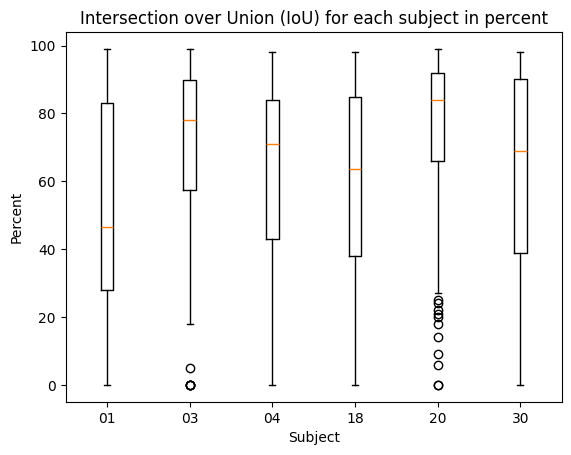

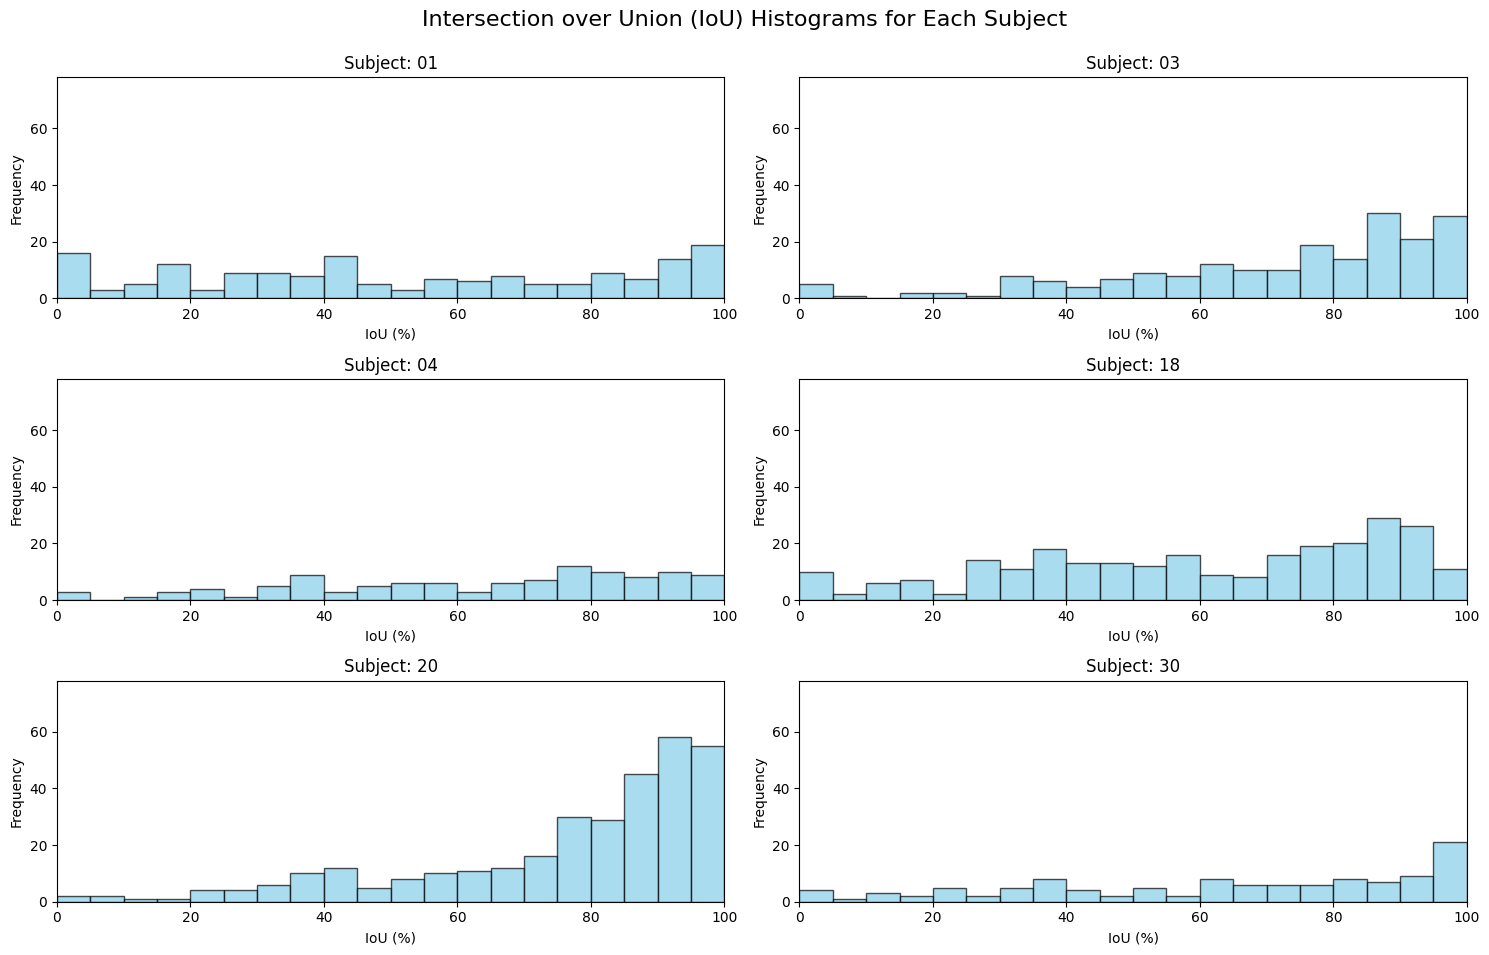

In [9]:
# Interseption over Union aka Jaccard Index for start end times intersections
def calculate_iou(labels1, labels2):
    start1 = 0
    start2 = 0
    end1 = 0
    end2 = 0
    if len(labels1) == 1:
        start1 = labels1.iloc[0]['start']
        end1 = labels1.iloc[0]['end']
    if len(labels2) == 1:
        start2 = labels2.iloc[0]['start']
        end2 = labels2.iloc[0]['end']
    if start1 == 0 or start2 == 0:
        return 0
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    intersection = max(0, (intersection_end - intersection_start).total_seconds())
    union = (end1 - start1).total_seconds() + (end2 - start2).total_seconds() - intersection
    iou = intersection / union if union != 0 else 0
    return iou
    

all_results = []
all_iou_values = []
for subject in subjects:
    results = []
    annotator_dfs = []
    path = os.path.join(labels_windows_clean, f"subject_{subject}.csv")
    window_df = pd.read_csv(path)
    window_df['start'] = pd.to_datetime(window_df['start'])
    window_df['end'] = pd.to_datetime(window_df['end'])
    
    for annotator in annotators:
        annotation_path = os.path.join(clean_labels_path, f"{annotator}_subject_{subject}.csv")
        if os.path.exists(annotation_path):
            df = pd.read_csv(annotation_path)
            df['start'] = pd.to_datetime(df['start'])
            df['end'] = pd.to_datetime(df['end'])
            annotator_dfs.append(df)
 
    for _, window_row in window_df.iterrows():
        window_start = window_row['start']
        window_end = window_row['end']
        matching_labels_annotator1 = annotator_dfs[0][
            (annotator_dfs[0]['start'] >= window_start) & 
            (annotator_dfs[0]['start'] <= window_end)
        ]
                
        matching_labels_annotator2 = annotator_dfs[1][
            (annotator_dfs[1]['start'] >= window_start) & 
            (annotator_dfs[1]['start'] <= window_end)
        ]

        if len(matching_labels_annotator1) > 1 or len(matching_labels_annotator2) > 1:
            print("more than one label")
        elif len(matching_labels_annotator1) == 1 and len(matching_labels_annotator2) == 1:
            iou = calculate_iou(matching_labels_annotator1, matching_labels_annotator2)
            results.append({'subject': subject, "iou": iou})
            all_iou_values.append(iou)
    subject_df = pd.DataFrame(results)
    all_results.append(subject_df)




# Plotting
fig, ax = plt.subplots()
positions = []
labels = []

for i, subject_df in enumerate(all_results):
    subject = subject_df['subject'].iloc[0]
    subject_df['iou'] = (subject_df['iou'] * 100).astype(int)  
    ax.boxplot(subject_df['iou'], positions=[i], labels=[subject])
    positions.append(i)
    labels.append(subject)

ax.set_xlabel('Subject')
ax.set_ylabel('Percent')
ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.title('Intersection over Union (IoU) for each subject in percent')
plot_filename = 'iou_boxplot.png'
plt.savefig(plot_filename)
plt.show()

#histogramm
combined_results_df = pd.concat(all_results, ignore_index=True)

all_ious = combined_results_df['iou'] * 100
bin_width = 5
bins = np.arange(0, 105, bin_width)  
y_max = 0
for subject_df in all_results:
    counts, _ = np.histogram(subject_df['iou'], bins=bins)
    y_max = max(y_max, max(counts))

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

for i, subject_df in enumerate(all_results):
    subject = subject_df['subject'].iloc[0]
    axes[i].hist(subject_df['iou'], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Subject: {subject}')
    axes[i].set_xlim(0, 100)
    axes[i].set_ylim(0, y_max+20)
    axes[i].set_xlabel('IoU (%)')
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Intersection over Union (IoU) Histograms for Each Subject', fontsize=16)
plot_filename = 'iou_histograms.png'
plt.savefig(plot_filename)
plt.show()


subject 01
{'pp': 35, 'pn': 16, 'np': 94, 'nn': 23}
subject 03
{'pp': 40, 'pn': 46, 'np': 53, 'nn': 59}
subject 04
{'pp': 37, 'pn': 44, 'np': 16, 'nn': 14}
subject 18
{'pp': 17, 'pn': 208, 'np': 3, 'nn': 34}
subject 20
{'pp': 141, 'pn': 2, 'np': 168, 'nn': 10}
subject 30
{'pp': 14, 'pn': 54, 'np': 4, 'nn': 42}
  subject  start_rmse  start_mean  start_tsd  start_variance   end_rmse  \
0      01   87.197918   52.613214  69.536513     4835.326575  37.059595   
1      03   16.644243    9.386667  13.744865      188.921317  11.353557   
2      04   34.193319   16.561802  29.914709      894.889799  17.918302   
3      18   27.343972   15.043053  22.834171      521.399362  17.828431   
4      20   18.786780    7.024735  17.424012      303.596179   5.788664   
5      30   68.604662   34.313333  59.407027     3529.194826  16.417790   

    end_mean    end_std  end_variance  
0  16.908214  32.977657   1087.525868  
1   5.548283   9.905545     98.119818  
2   7.615856  16.219257    263.064289  
3 

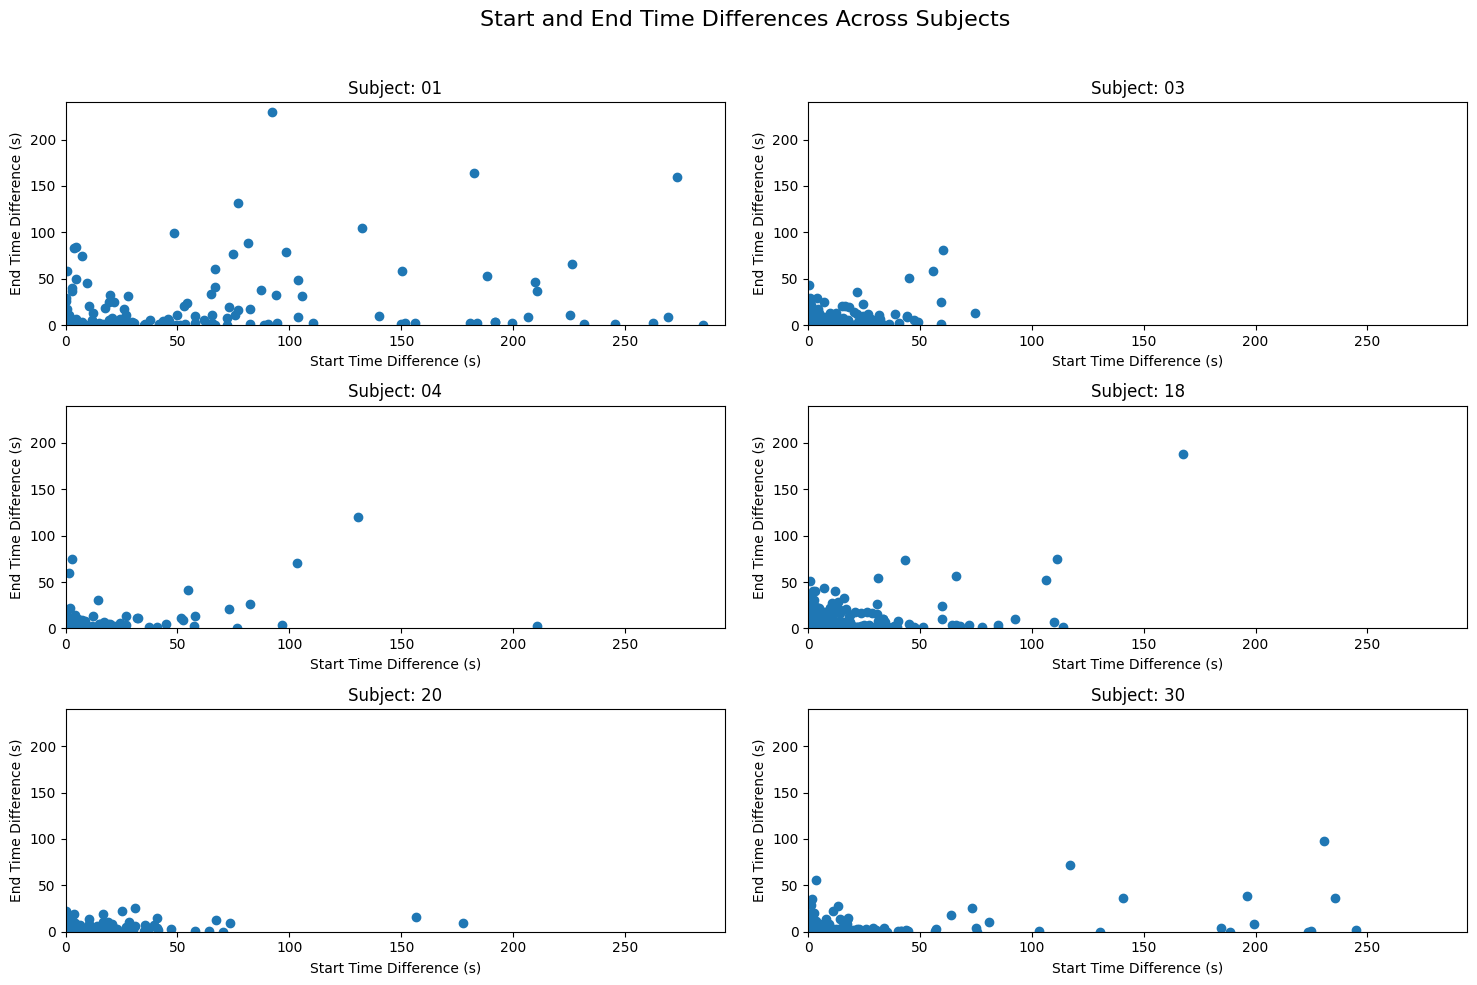

"\ncombined_results_df_new = combined_results_df\ncombined_results_df_new['start'] = abs(combined_results_df_new['start'])\ncombined_results_df_new['end'] = abs(combined_results_df_new['end'])\n#histogramms\n\nall_start_times =  combined_results_df_new['start']\nall_end_times = combined_results_df_new['end']\n# Calculate the range of start and end times across all subjects\nstart_range = np.ptp(all_start_times)\nend_range = np.ptp(all_end_times)\n\n# Calculate the bin width based on the range and number of bins\nbin_width = max(start_range, end_range) / 20\n\n# Plotting\nfig, axes = plt.subplots(len(subjects), 2, figsize=(15, 20), sharex='col')\n\nfor i, subject in enumerate(subjects):\n    subject_df = combined_results_df_new[combined_results_df_new['subject'] == subject]\n    \n    axes[i, 0].hist(subject_df['start'], bins=np.arange(min(all_start_times), max(all_start_times) + bin_width, bin_width), color='skyblue', edgecolor='black', alpha=0.7)\n    axes[i, 0].set_title(f'Subject: {

In [10]:
# calculate time differences between pairs of annotations
def get_cont_matrix(df, subject):

    contigency_matrix = {
    'pp': 0,
    'pn': 0,
    'np': 0,
    'nn': 0
    }

    for index, row in df.iterrows():
        if row['start']>0 and row['end']>0:
            contigency_matrix['pp'] += 1
        elif row['start']>0 and row['end']<0:
            contigency_matrix['pn'] += 1
        elif row['start']<0 and row['end']>0:
            contigency_matrix['np'] += 1
        else:
            contigency_matrix['nn'] += 1
    print('subject', subject)
    print(contigency_matrix)
def calculate_rmse(differences):
    return np.sqrt(np.mean(np.square(differences)))
    
def calculate_differences(annotator1, annotator2):
    
    start = (annotator2['start'] - annotator1['start']).total_seconds()
    end = (annotator2['end'] - annotator1['end']).total_seconds()
    
    return start, end
def calculate_statistics(differences):
    new_diff = abs(differences)
    mean = np.mean(new_diff)
    variance = np.var(new_diff)
    std = np.std(new_diff)
    rmse = np.sqrt(np.mean(np.square(new_diff)))
    return rmse, mean, std, variance

all_results = []
max_freq = 0
for subject in subjects:
    results = []
    annotator_dfs = []
    path = os.path.join(labels_windows_clean, f"subject_{subject}.csv")
    window_df = pd.read_csv(path)
    window_df['start'] = pd.to_datetime(window_df['start'])
    window_df['end'] = pd.to_datetime(window_df['end'])
    
    for annotator in annotators:
        annotation_path = os.path.join(clean_labels_path, f"{annotator}_subject_{subject}.csv")
        if os.path.exists(annotation_path):
            df = pd.read_csv(annotation_path)
            df['start'] = pd.to_datetime(df['start'])
            df['end'] = pd.to_datetime(df['end'])
            annotator_dfs.append(df)
 
    for _, window_row in window_df.iterrows():
        window_start = window_row['start']
        window_end = window_row['end']
        matching_labels_annotator1 = annotator_dfs[0][
            (annotator_dfs[0]['start'] >= window_start) & 
            (annotator_dfs[0]['start'] <= window_end)
        ]
                
        matching_labels_annotator2 = annotator_dfs[1][
            (annotator_dfs[1]['start'] >= window_start) & 
            (annotator_dfs[1]['start'] <= window_end)
        ]

        if len(matching_labels_annotator1) > 1 or len(matching_labels_annotator2) > 1:
            print("more than one label")
        elif len(matching_labels_annotator1) == 1 and len(matching_labels_annotator2) == 1:
            start, end = calculate_differences(matching_labels_annotator1.iloc[0], matching_labels_annotator2.iloc[0])
            #temp
            
            results.append({'subject': subject, "start": start, "end": end})
            
    
    
    subject_df = pd.DataFrame(results)
    get_cont_matrix(subject_df, subject)
    all_results.append(subject_df)

    # Calculate the maximum frequency for each subject
    start_hist, _ = np.histogram(subject_df['start'], bins=20)
    end_hist, _ = np.histogram(subject_df['end'], bins=20)
    max_freq = max(max_freq, max(start_hist), max(end_hist))
    
combined_results_df = pd.concat(all_results, ignore_index=True)

statistics_results = []
for subject in subjects:
    subject_df = combined_results_df[combined_results_df['subject'] == subject]
    start_rmse, start_mean, start_std, start_variance = calculate_statistics(subject_df['start'])
    end_rmse, end_mean, end_std, end_variance = calculate_statistics(subject_df['end'])
    statistics_results.append({
        'subject': subject,
        'start_rmse': start_rmse, 'start_mean': start_mean, 'start_tsd': start_std, 'start_variance': start_variance,
        'end_rmse': end_rmse, 'end_mean': end_mean, 'end_std': end_std, 'end_variance': end_variance
    })

statistics_df = pd.DataFrame(statistics_results)
print(statistics_df)

# Plotting
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Start and End Time Differences Across Subjects', fontsize=16)

all_start_diffs = combined_results_df['start'].abs() 
all_end_diffs = combined_results_df['end'].abs()  
x_limits = (0, max(all_start_diffs) + 10)  
y_limits = (0, max(all_end_diffs) + 10)
 

for i, subject in enumerate(subjects):
    row = i // cols
    col = i % cols
    subject_df = combined_results_df[combined_results_df['subject'] == subject]
    
    axes[row, col].scatter(abs(subject_df['start']), abs(subject_df['end']))
    axes[row, col].set_title(f'Subject: {subject}')
    axes[row, col].set_xlim(x_limits)
    axes[row, col].set_ylim(y_limits)
    #axes[row, col].legend()
     # Set major and minor ticks
plt.subplots_adjust(hspace=200, wspace=400)
for ax in axes.flat:
    ax.label_outer()   
    ax.set_xlabel('Start Time Difference (s)')
    ax.set_ylabel('End Time Difference (s)')
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    ax.yaxis.set_tick_params(which='both', labelleft=True)
    

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.savefig('start_end_time_differences.png')
plt.show()
'''
combined_results_df_new = combined_results_df
combined_results_df_new['start'] = abs(combined_results_df_new['start'])
combined_results_df_new['end'] = abs(combined_results_df_new['end'])
#histogramms

all_start_times =  combined_results_df_new['start']
all_end_times = combined_results_df_new['end']
# Calculate the range of start and end times across all subjects
start_range = np.ptp(all_start_times)
end_range = np.ptp(all_end_times)

# Calculate the bin width based on the range and number of bins
bin_width = max(start_range, end_range) / 20

# Plotting
fig, axes = plt.subplots(len(subjects), 2, figsize=(15, 20), sharex='col')

for i, subject in enumerate(subjects):
    subject_df = combined_results_df_new[combined_results_df_new['subject'] == subject]
    
    axes[i, 0].hist(subject_df['start'], bins=np.arange(min(all_start_times), max(all_start_times) + bin_width, bin_width), color='skyblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'Subject: {subject} Start Time')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].set_ylim(0, max_freq+100)
    
    axes[i, 1].hist(subject_df['end'], bins=np.arange(min(all_end_times), max(all_end_times) + bin_width, bin_width), color='salmon', edgecolor='black', alpha=0.7)
    axes[i, 1].set_title(f'Subject: {subject} End Time')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].set_ylim(0, max_freq+100)
plt.tight_layout()
plt.savefig('hisrogramm_distances.png')
plt.show()
'''